In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import glob
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [2]:
files=glob.glob('../stock-data-dow-jones/*.csv')
#files=glob.glob('stock-data-dow-jones/*.txt')
df = pd.read_csv(files[9],index_col = 0)

In [3]:
df['log_return'] = [0.0]*df.shape[0]
for i in range(1,df.shape[0]):
    df['log_return'][i]=np.log(df['close'][i]/df['close'][i-1])*100

C:\Users\maxle\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
df.head()

,open,high,low,close,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime,log_return
date,,,,,,,,,,,,
2014-06-12,71.3999,71.4447,70.0297,70.2357,7644311,7644311,-1.235800,-1.729,70.4775,"Jun 12, 14",0.000000,0.000000
2014-06-13,70.2894,70.3790,69.6268,69.9133,7971901,7971901,-0.322386,-0.459,69.8697,"Jun 13, 14",-0.004590,-0.460083
2014-06-16,69.8148,70.8268,69.8148,70.6566,7171923,7171923,0.743280,1.063,70.5997,"Jun 16, 14",0.005993,1.057562
2014-06-17,70.6029,72.0536,70.5044,71.6596,9587295,9587295,1.003000,1.420,71.5279,"Jun 17, 14",0.020273,1.409561
2014-06-18,71.6685,72.3223,71.4536,72.2775,8071483,8071483,0.617911,0.862,71.9719,"Jun 18, 14",0.029071,0.858575


In [5]:
df['volatility']=np.log(np.sqrt(pow((df['log_return']-df['log_return'].mean()),2)))

In [35]:
#df['volatility']=pow(df['log_return'],2)

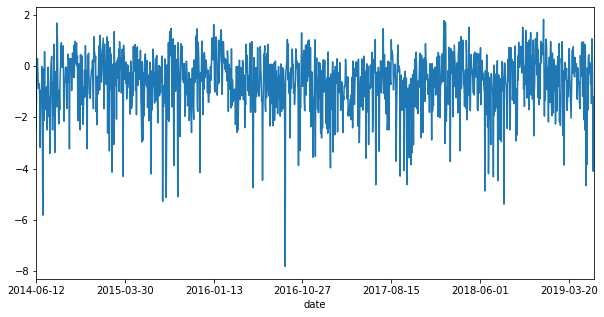

In [6]:
plt.figure(figsize = (10,5))
fg = df.volatility.plot()

In [223]:
'''
df_train = df['volatility'][df.index < "2017-03-01"]

df_val = df['volatility'][(df.index >= "2017-03-01") & (df.index < "2018-05-01")]

df_test = df['volatility'][df.index >= "2018-05-01"]

df_train = np.array(df_train).reshape(-1,1)
df_val = np.array(df_val).reshape(-1,1)
df_test = np.array(df_test).reshape(-1,1)
'''

In [7]:
# normalize the dataset
scaler1 = MinMaxScaler(feature_range=(0, 1))
df_x = np.array(df.volatility).reshape(-1,1)
df_x = scaler1.fit_transform(df_x)

scaler2 = MinMaxScaler(feature_range=(0, 1))
df_y = np.array(df.volatility).reshape(-1,1)
df_y = scaler2.fit_transform(df_y)

In [8]:
def create_dataset(df_x, df_y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(df)-look_back):
        a = df_x[i:(i+look_back)]
        dataX.append(a)
        dataY.append(df_y[i+look_back])
    return np.array(dataX), np.array(dataY)
look_back = 10
data_X, data_Y = create_dataset(df_x, df_y, look_back)

In [9]:
data_X.shape

(1248, 10, 1)

In [10]:
# split into train and test sets
train_size = (int(len(df_y ) * 0.8) // 100) * 100
test_size = ((len(df_y) - train_size) // 100) * 100
df_x = df_x[:train_size+test_size]
df_y = df_y[:train_size+test_size]
data_X = data_X[:train_size+test_size]
data_Y = data_Y[:train_size+test_size]
trainX, testX = data_X[0:train_size], data_X[train_size:train_size + test_size]
trainY, testY = data_Y[0:train_size], data_Y[train_size:train_size + test_size]
trainX.shape

(1000, 10, 1)

In [11]:
# reshape input to be [samples, time steps, features]
trainX = trainX.reshape((-1, look_back, 1))
testX = testX.reshape( (-1, look_back, 1))
trainY = trainY.reshape((-1, 1))
testY = testY.reshape( (-1, 1))


In [12]:
testX.shape

(200, 10, 1)

In [13]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(50, activation='relu', input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(25, activation='relu', input_shape=(look_back, 1), return_sequences=False))
#model.add(LSTM(20, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=30, verbose=1)

Epoch 1/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1667
Epoch 2/30
1000/1000 [==============================] - 1s 702us/step - loss: 0.0158
Epoch 3/30
1000/1000 [==============================] - 1s 854us/step - loss: 0.0142
Epoch 4/30
1000/1000 [==============================] - 1s 796us/step - loss: 0.0144
Epoch 5/30
1000/1000 [==============================] - 1s 958us/step - loss: 0.0152
Epoch 6/30
1000/1000 [==============================] - 1s 919us/step - loss: 0.0141
Epoch 7/30
1000/1000 [==============================] - 1s 883us/step - loss: 0.0142 0s - lo
Epoch 8/30
1000/1000 [==============================] - 1s 895us/step - loss: 0.0140
Epoch 9/30
1000/1000 [==============================] - 1s 795us/step - loss: 0.0145
Epoch 10/30
1000/1000 [==============================] - 1s 705us/step - loss: 0.0146
Epoch 11/30
1000/1000 [==============================] - 1s 710us/step - loss: 0.0143
Epoch 12/30
1000/1000 [==============================] - 

In [14]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler2.inverse_transform(trainPredict)

trainY = scaler2.inverse_transform(trainY)
testPredict = scaler2.inverse_transform(testPredict)
testY = scaler2.inverse_transform(testY)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('R^2 train: %.3f' % (r2_score(trainY, trainPredict[:,0])))
print('R^2 test: %.3f' % (r2_score(trainY, trainPredict[:,0])))

Train Score: 1.14 RMSE
Test Score: 1.20 RMSE
R^2 train: 0.002
R^2 test: 0.002


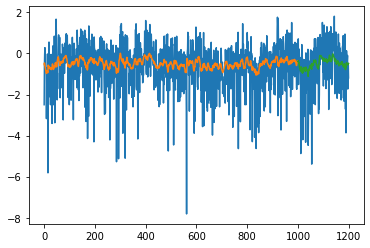

In [15]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_x)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[0:len(trainPredict), :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_x)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):len(df_x), :] = testPredict
# plot baseline and predictions
#plt.figure(figsize=(100,5))
plt.plot(scaler2.inverse_transform(df_y))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
#plt.plot(df.log_return)
plt.show()